# Object Detection with RefineDet

In [34]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.utils.data as data
from PIL import Image
from libs.networks.vgg_refinedet import VGGRefineDet
from libs.networks.resnet_refinedet import ResNetRefineDet
from libs.dataset.config import voc320, voc512, coco320, coco512, MEANS
from libs.dataset.transform import detection_collate, BaseTransform
from libs.dataset.roidb import combined_roidb, get_output_dir
from libs.dataset.blob_dataset import BlobDataset
import cv2
from matplotlib import pyplot as plt

is_gpu = False
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    is_gpu = True


Create or load an evaluted imdb.
Loaded dataset `voc_2007_test` for training
Preparing training data...
voc_2007_test gt roidb loaded from /root/workspace/pytorch_proj/proj/pytorch_refinedet/data/cache/voc_2007_test_gt_roidb.pkl
done
Construct vgg16_refinedet network.
Initializing weights...


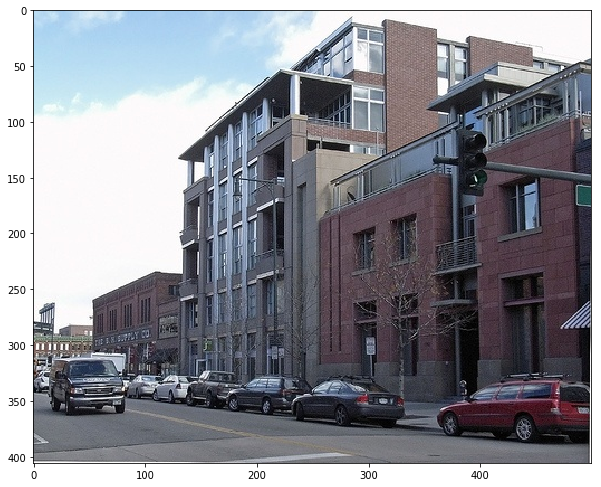

In [35]:
imdbval_name = 'voc_2007_test'
cfg = voc320
base_network = 'vgg16' 
model_path = '../weights/vgg16_refinedet320_voc_120000.pth'
# Create imdb, roidb and blob_dataset
print('Create or load an evaluted imdb.')
imdb, roidb = combined_roidb(imdbval_name, False)
class_names = imdb.classes
num_classes = imdb.num_classes

# Construct networks based on VGG16.
print('Construct {}_refinedet network.'.format(base_network))
refinedet = VGGRefineDet(cfg['num_classes'], cfg)
refinedet.create_architecture()
# For CPU
net = refinedet
# For GPU/GPUs
if is_gpu:
    net = refinedet.cuda()
    cudnn.benchmark = True
# Load weights
net.load_weights(model_path)
net.eval()


# Select an image.
idx = 3
img_path = imdb.image_path_at(idx)
image = cv2.imread(img_path, cv2.IMREAD_COLOR)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()


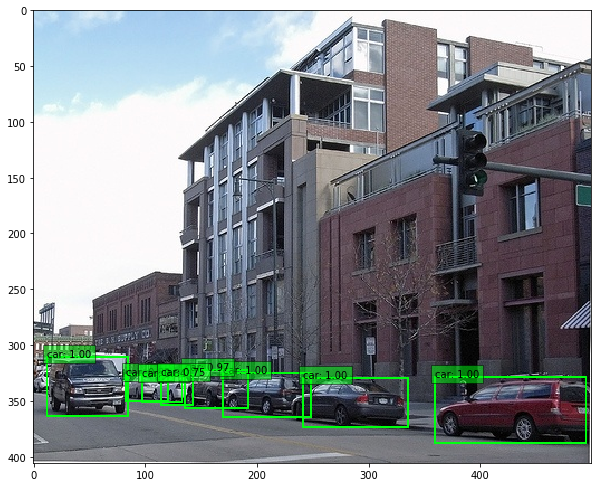

In [36]:
# Preprocess
norm_image = cv2.resize(image, (320, 320)).astype(np.float32)
norm_image -= (104.0, 117.0, 123.0)
norm_image = norm_image.astype(np.float32)
norm_image = norm_image[:, :, ::-1].copy()
norm_image = torch.from_numpy(norm_image).permute(2, 0, 1)

# Forward
input_var = Variable(norm_image.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    input_var = input_var.cuda()
detection = net(input_var)


top_k=10
# num_classes = 1
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(1, detection.size(1)):
    j = 0
    while detection[0,i,j,0] >= 0.5:
        score = detection[0,i,j,0]
#         print(score)
        label_name = class_names[i]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detection[0,i,j,1:]*scale).cpu().numpy()
#         print(pt)
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
    